In [62]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import RK45, odeint, solve_ivp
from scipy.special import expit
import math
from tqdm import tqdm
plt.style.use(['science','notebook','grid'])
from scipy.fft import fft, fftfreq, ifft, fftshift, ifftshift, ifft
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

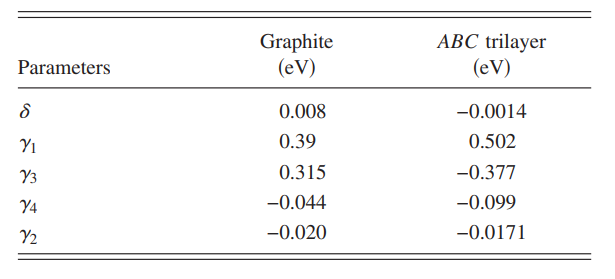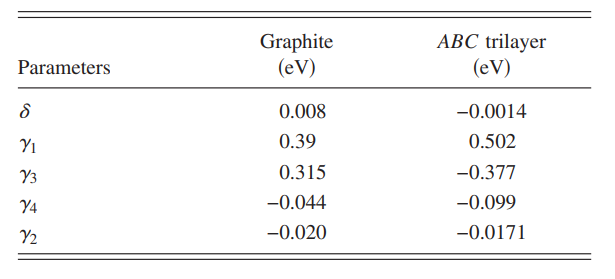


In [63]:
a = 0.246
hbar =1
γ0 = 3.16

δ = 0.008
δT = -0.0014
Par = np.array([ γ0, 0.39, -0.020, 0.315, -0.044]) #Respectively γ 0 1 2 3 4, graphite bulk
Parv = Par*(3**0.5*a/(2*hbar))
ParTLG = np.array([ γ0, 0.502, -0.0171, -0.377, -0.099]) #Respectively γ 0 1 2 3 4, TLG 
ParvTLG = ParTLG*(3**0.5*a/(2*hbar))


In [64]:
N = 720; #16
b = 10**-3
G = 4*np.pi/(np.sqrt(3)*a)
p_spacex, p_spacey = 2.5*np.mgrid[-10*b:10*b:N*1j,-10*b:10*b:N*1j]*G
p_spacex1, p_spacey1 = 2.5*np.mgrid[-10*b:10*b:N*1j,-10*b:10*b:N*1j]*G

om = 20*10**-3;
σx = np.array([[0, 1],[1, 0]]); σy = np.array([[0, -1j],[1j, 0]]); σz = np.array([[1, 0],[0, -1]])


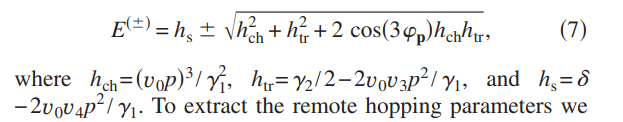
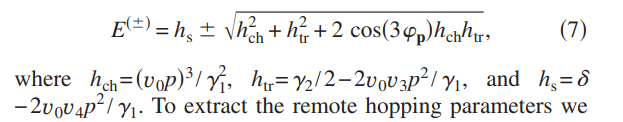

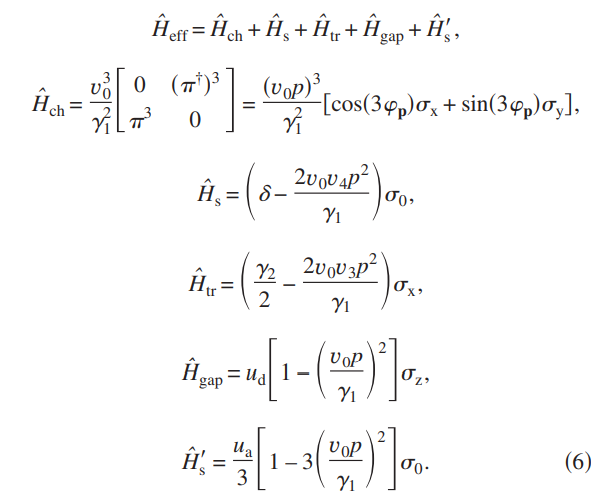


In [65]:
ud = 0.0*ParTLG[1];
ua = 0.0;
def HTLG(kx,ky):
    k = (kx**2+ky**2)**0.5
    Hch = ((4*((kx)/(k))**3-3*(kx)/(k))*σx+(3*ky/k-4*(ky/k)**3)*σy)*(ParvTLG[0]*k)**3/ParTLG[1]**2; 
    Hs1 = (δ-2*ParvTLG[0]*ParvTLG[4]*k**2/ParTLG[1])*np.eye(2); 
    Htr = (ParTLG[2]/2-2*ParvTLG[0]*ParvTLG[3]*k**2/ParTLG[1])*σx; 
    Hgap = ud*(1-(ParvTLG[0]*k/ParTLG[1])**2)*σz; 
    Hs2 = ua/3*(1-3*(ParvTLG[0]*k/ParTLG[1])**2)*np.eye(2);
    return Hch+Hs1+Htr+Hgap+Hs2

In [66]:
from numpy import linalg as LA
η = 0.001
def G0(kx,ky, ω = om):
    Ham = HTLG(kx,ky); 
    λ, v = LA.eig(Ham)
    summ = np.zeros([2,2], dtype = 'complex')
    for n in range(len(λ)):
        g = np.power((ω+1j*0.01-λ[n]),(-1))
        ψ = v[n].T
        ψ2 = ψ.conj()
        summ = summ+g*np.array([[ψ[0]*ψ2[0],ψ[0]*ψ2[1]],[ψ[1]*ψ2[0],ψ[1]*ψ2[1]]])
    return summ

In [67]:
V = 0.1*np.array([[1, 0],[0, -1]])

In [68]:
from numpy.linalg import inv
G0Mp = np.zeros([N,N,2,2], dtype = 'complex')
for i in tqdm(range(N), desc="G0-Matrix"):
        for j in range(N):
            G0Mp[i,j] = G0(p_spacex[i, j], p_spacey[i, j] , om)
# def T(ω = om):
#     summm = np.zeros([2,2])
#     for i in tqdm(range(N), desc="T-Matrix"):
#         for j in range(N):
#             summm = summm + G0Mp[i,j]
#     print(summm)
#     return np.dot(inv(np.eye(2)-np.dot(V, summm/N)), V)

G0-Matrix: 100%|██████████| 720/720 [00:55<00:00, 13.02it/s]


In [69]:
var = np.zeros([len(p_spacex),len(p_spacex)])
zeta = 0.00
def A(kx, ky):
    return -1/np.pi*np.imag(np.trace(G0(kx, ky, zeta)))

for i in tqdm(range(N), desc="Spectral Function Iterations"):
    for j in range(N):
        var[i, j] = A(p_spacex1[i, j], p_spacey1[i, j])/np.pi

        
        

Spectral Function Iterations: 100%|██████████| 720/720 [01:00<00:00, 11.89it/s]


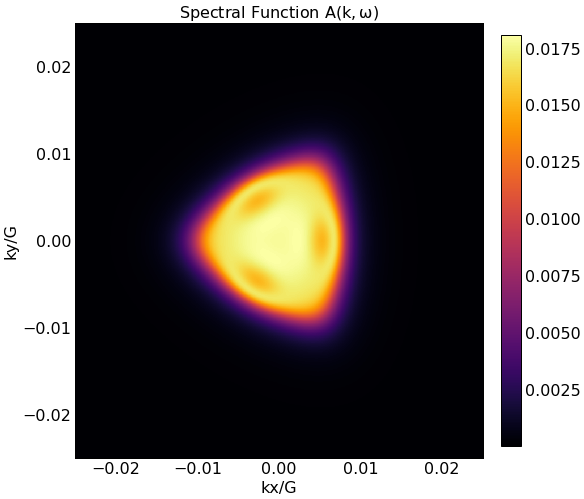

In [70]:
plt.figure(figsize=(8,8))
plt.pcolormesh(p_spacex1/G,p_spacey1/G, var/N,  shading = 'auto', cmap = 'inferno')
plt.title("Spectral Function $A(k, ω)$")
plt.colorbar(fraction=0.046, pad=0.04)
plt.xlabel("kx/G")
plt.ylabel("ky/G")
plt.savefig('Fermi abc'+str(int((zeta*100))), bbox_inches='tight')

plt.show()

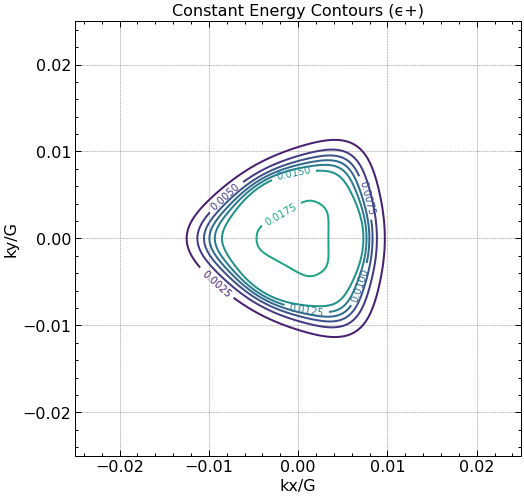

In [71]:
plt.figure(figsize=(8,8))
CS = plt.contour(p_spacex1/G,p_spacey1/G,var/N, levels = np.linspace(0.00, 0.03, 13) )
#CS = plt.contour(k_spacex,k_spacey, Em(k_spacex, k_spacey), levels = np.linspace(0.0*10**80,0.03,7) )
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Constant Energy Contours (ϵ+)')
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)
#labels = ['ω = 0.05','ω =0.3']
# for i in range(len(labels)):
#     CS.collections[i].set_label(labels[i])
plt.xlabel("kx/G")
plt.ylabel("ky/G")
plt.savefig('contours abc'+str(int(zeta*100)), bbox_inches='tight')


plt.show()

In [72]:
def T(ω = om):
    summm = np.zeros([2,2])

    for i in tqdm(range(N), desc="T-Matrix"):
        for j in range(N):
            summm = summm + G0Mp[i,j]
            

    return np.dot(inv(np.eye(2)-np.dot(V, summm/N**2)), V)

In [73]:
T1 = T(om) #outside of function speeds up

T-Matrix: 100%|██████████| 720/720 [00:00<00:00, 1432.39it/s]


In [74]:
sol = np.zeros((N,N))
G0Mm = np.zeros([N,N,2,2], dtype = 'complex')
for i in tqdm(range(N), desc="G0-Matrix"):
        for j in range(N):
            G0Mm[i,j] = G0(-p_spacex[i, j], -p_spacey[i, j] , om)
            

G0-Matrix: 100%|██████████| 720/720 [00:56<00:00, 12.75it/s]


In [75]:
G0Mpconj = np.zeros([N,N,2,2], dtype = 'complex')
G0Mmconj = np.zeros([N,N,2,2], dtype = 'complex')

for i in tqdm(range(N), desc="G0-Matrix HT"):
        for j in range(N):
            G0Mpconj[i,j] = G0Mp[i,j].conj().T
            
for i in tqdm(range(N), desc="G0-Matrix HT"):
        for j in range(N):
            G0Mmconj[i,j] = G0Mm[i,j].conj().T

print()

G0-Matrix HT: 100%|██████████| 720/720 [00:00<00:00, 825.31it/s]

In [76]:
#print(G0M[:,:,0,0])
#print(G0M[:,:,0,0])
def DOS(w = om):
    fact = 1j/(2*np.pi)
    res = np.zeros([N,N], dtype = 'complex')
    T2 = T1.conj().T
    for m in range(2):
        for n in range(2):
            for j in tqdm(range(2), desc="G0-Matrix"):
                Gp1 = (np.fft.fft2(fftshift(G0Mp[:,:,n,j])))
                Gm1 = (np.fft.fft2(fftshift(G0Mm[:,:,j,m])))
                G1 = ifftshift(np.fft.ifft2((((Gp1)*(Gm1)))))
                Gp2 = (np.fft.fft2(fftshift(G0Mmconj[:,:,n,j])))
                Gm2 = (np.fft.fft2(fftshift(G0Mpconj[:,:,j,m])))
                G2 = ifftshift(np.fft.ifft2(((Gp2*Gm2))))
                res = res+T1[m,n]*(G1)-(T2[m,n]*(G2))
            
    
    sol = (np.abs((fact*res)))
    return sol

In [77]:
sol = DOS()*20

G0-Matrix: 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


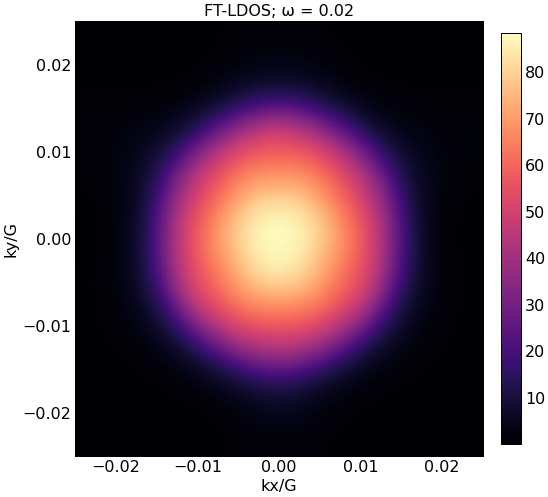

In [84]:
plt.figure(figsize=(8,8))
v1 = 0.35; v2 = 2.25
plt.pcolormesh(p_spacex/G,p_spacey/G, sol/N**2, cmap = "magma", shading = 'auto')#, vmin = 80) #,vmin = 1500/5000)
plt.title("FT-LDOS; ω = "+str(om))
plt.xlabel("kx/G")
plt.ylabel("ky/G")

plt.colorbar(fraction=0.046, pad=0.04)
plt.savefig('QPI, abc z ud actual'+str(int(1000*om)), bbox_inches='tight')
plt.show()

In [79]:
# %matplotlib inline
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import animation
# omega = np.linspace(0,0.3, 100)
# fig, ax = plt.subplots(figsize=(11,11))
# ax.set_aspect('equal')
# ti = ax.set_title("FT-LDOS, ω = 0-0.3 eV")
# ti = ax.set_xlabel("kx/G")
# ti = ax.set_ylabel("ky/G")

# ims = []
# for om in tqdm(omega, desc="Calc"):
#     G0Mp = np.zeros([N,N,2,2], dtype = 'complex')
#     for i in range(N):
#         for j in range(N):
#             G0Mp[i,j] = G0(p_spacex[i, j], p_spacey[i, j] , om)
#     T1 = T(om)
#     G0Mm = np.zeros([N,N,2,2], dtype = 'complex')
#     for i in range(N):
#         for j in range(N):
#             G0Mm[i,j] = G0(-p_spacex[i, j], -p_spacey[i, j] , om)
#     G0Mpconj = np.zeros([N,N,2,2], dtype = 'complex')
#     G0Mmconj = np.zeros([N,N,2,2], dtype = 'complex')

#     for i in range(N):
#             for j in range(N):
#                 G0Mpconj[i,j] = G0Mp[i,j].conj().T

#     for i in range(N):
#             for j in range(N):
#                 G0Mmconj[i,j] = G0Mm[i,j].conj().T
                
#     sol = DOS(om)*20
#     im = ax.pcolormesh(p_spacex/G,p_spacey/G, sol/N**2, cmap = "magma", shading = 'auto')
#     ti.set_text("FT-LDOS, ω ={}".format(om))
#     ims.append([im])
    
# ani = animation.ArtistAnimation(fig, ims, interval = 50)
# plt.close()
# ani.save("animation w ABC z ud 005.mp4")
# plt.show()

In [80]:
# %matplotlib inline
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import animation
# r = 100
# val = np.linspace(0,2*ParTLG[1],r)
# fig, ax = plt.subplots(figsize=(11,11))
# ax.set_aspect('equal')
# ti = ax.set_title("FT-LDOS, ω = "+str(om)+" ud = 0.00 - 2*γ1")

# def HTLG(kx,ky,u):
#         k = (kx**2+ky**2)**0.5
#         Hch = ((4*((kx)/(k))**3-3*(kx)/(k))*σx+(3*ky/k-4*(ky/k)**3)*σy)*(Parv[0]*k)**3/Par[1]**2; 
#         Hs1 = (δ-2*Parv[0]*Parv[4]*k**2/Par[1])*np.eye(2); 
#         Htr = (Par[2]/2-2*Parv[0]*Parv[3]*k**2/Par[1])*σx; 
#         Hgap = u*(1-(Parv[0]*k/Par[1])**2)*σz; 
#         Hs2 = ua/3*(1-3*(Parv[0]*k/Par[1])**2)*np.eye(2);
#         return Hch+Hs1+Htr+Hgap+Hs2
    
# def G0(kx,ky,u, ω = om):
#         Ham = HTLG(kx,ky,u); 
#         λ, v = LA.eig(Ham)
#         summ = np.zeros([2,2], dtype = 'complex')
#         for n in range(len(λ)):
#             g = np.power((ω+1j*0.01-λ[n]),(-1))
#             ψ = v[n].T
#             ψ2 = ψ.conj()
#             summ = summ+g*np.array([[ψ[0]*ψ2[0],ψ[0]*ψ2[1]],[ψ[1]*ψ2[0],ψ[1]*ψ2[1]]])
#         return summ

# ims = []
# print(val)
# for s in tqdm(range(r), desc="Calc"):
#     G0Mp = np.zeros([N,N,2,2], dtype = 'complex')
#     for i in range(N):
#         for j in range(N):
#             G0Mp[i,j] = G0(p_spacex[i, j], p_spacey[i, j], val[s])
#     T1 = T(om)
#     G0Mm = np.zeros([N,N,2,2], dtype = 'complex')
#     for i in range(N):
#         for j in range(N):
#             G0Mm[i,j] = G0(-p_spacex[i, j], -p_spacey[i, j], val[s])
#     G0Mpconj = np.zeros([N,N,2,2], dtype = 'complex')
#     G0Mmconj = np.zeros([N,N,2,2], dtype = 'complex')

#     for i in range(N):
#             for j in range(N):
#                 G0Mpconj[i,j] = G0Mp[i,j].conj().T

#     for i in range(N):
#             for j in range(N):
#                 G0Mmconj[i,j] = G0Mm[i,j].conj().T
                
#     sol = DOS(om)*20
#     im = ax.pcolormesh(p_spacex/G,p_spacey/G, sol/N**2, cmap = "magma", shading = 'auto')
#     ims.append([im])
    
# ani = animation.ArtistAnimation(fig, ims, interval = 50)
# plt.close()
# ani.save("animation w ABC z ud dependence.mp4")
# plt.show()